In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'JPXN'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_jpxn.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(5794, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2001-10-26,38.674999,38.724998,38.674999,38.724998,28.198915,3.339284,1.001293,0.979729,0.986443
2001-10-29,38.200001,38.200001,37.939999,37.939999,27.627289,3.318804,0.993194,1.000000,1.000000
2001-10-30,37.939999,37.939999,37.939999,37.939999,27.627289,3.318804,1.000000,0.990380,0.987085
2001-10-31,37.450001,37.575001,37.450001,37.575001,27.361502,3.309137,1.003338,1.005323,1.000000
2001-11-01,37.575001,37.775002,37.575001,37.775002,27.507139,3.314446,1.005323,0.999338,0.999338
2001-11-02,37.750000,37.750000,37.750000,37.750000,27.488932,3.313783,1.000000,1.000000,1.000000
2001-11-05,37.750000,37.750000,37.750000,37.750000,27.488932,3.313783,1.000000,1.015894,1.013245
2001-11-06,38.250000,38.349998,38.250000,38.349998,27.925846,3.329553,1.002614,0.976532,0.976532
2001-11-07,37.450001,37.450001,37.450001,37.450001,27.270491,3.305805,1.000000,1.009346,1.018024


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2001-10-26    38.724998
2001-10-29    38.200001
2001-10-31    37.575001
2001-11-01    37.775002
2001-11-06    38.349998
                ...    
2024-10-28    72.019997
2024-10-29    72.809998
2024-10-30    73.129997
2024-10-31    72.580002
2024-11-01    72.639999
Name: high, Length: 5416, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

5794

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

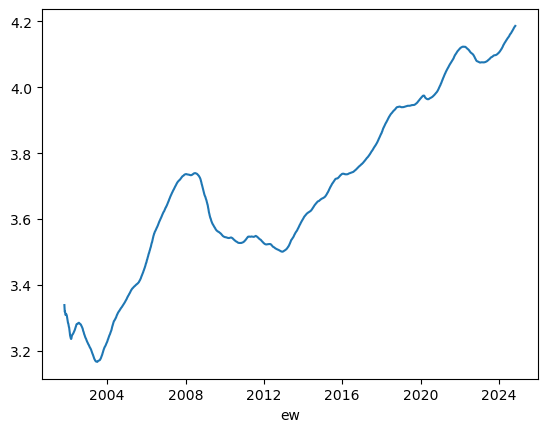

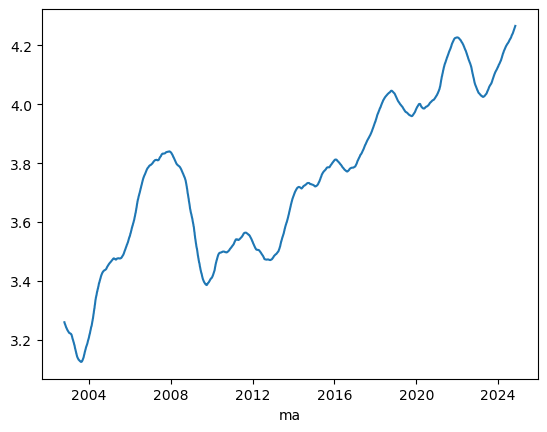

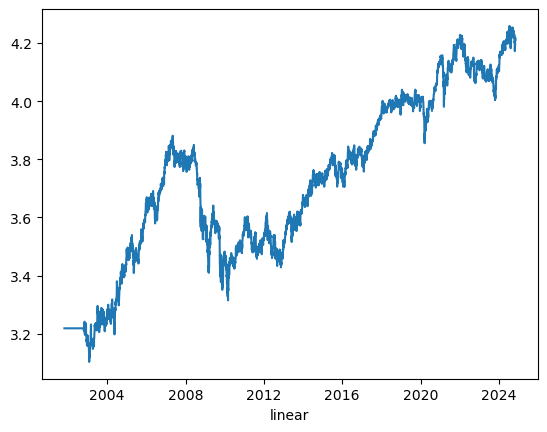

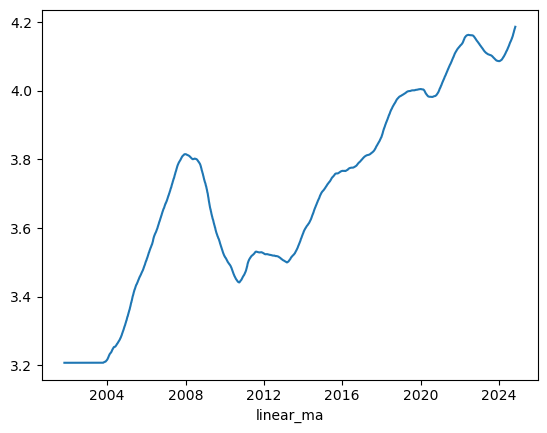

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(None, None)

Do nothing res: 2.2742273970372184
Round 1: 1.2111684605332613
New best: 1.2111684605332613
{'time_param': 246, 'method': 'linear_ma', 't': 0.7608910575804565, 'k': 0.10118811929604263, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


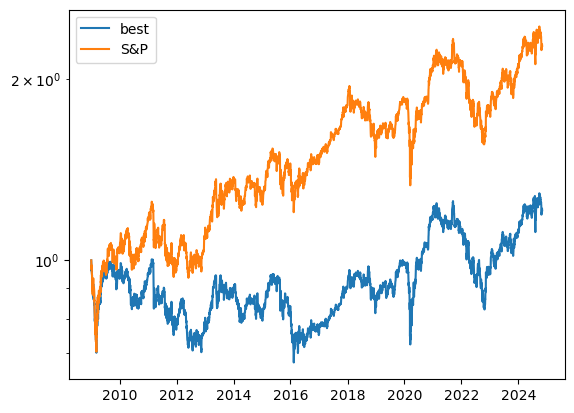

Round 2: 1.1502267402325397
Round 3: 1.47478846545485
New best: 1.47478846545485
{'time_param': 71, 'method': 'linear_ma', 't': 0.08574149728174141, 'k': 4.808439623182122, 'as_q': True, 'transform_f': 'bounded_curve'}


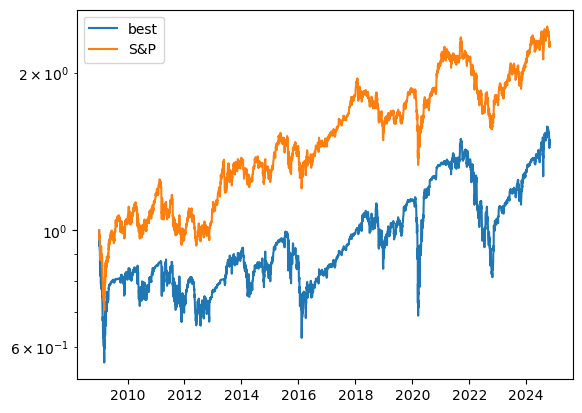

Round 4: 1.1555515686867266
Round 5: 1.119507850995489
Round 6: 1.1396076881763761
Round 7: 1.4959340731814026
New best: 1.4959340731814026
{'time_param': 124, 'method': 'ma', 't': 0.4438970958240557, 'k': 3.5865642016960817, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


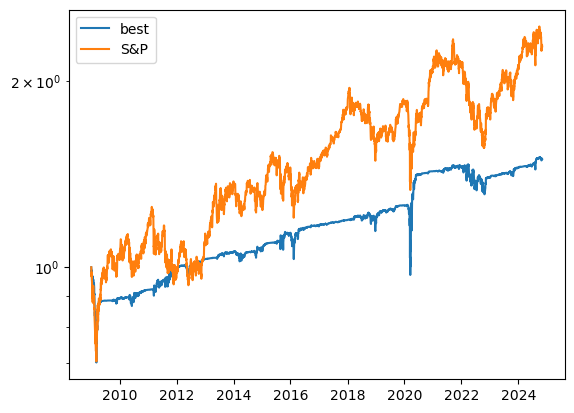

Round 8: 1.2353547546516168
Round 9: 1.2161782481549257
Round 10: 1.4448941315655226
Round 11: 1.641058173863014
New best: 1.641058173863014
{'time_param': 49, 'method': 'ew', 't': 0.681212401543213, 'k': 2.403634203543428, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


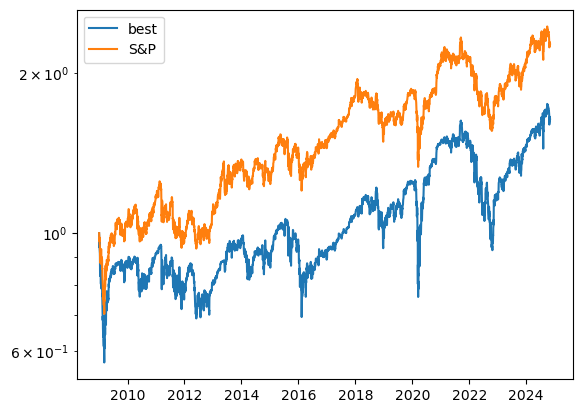

Round 12: 1.6254775721390962
Round 13: 1.1890890399863034
Round 14: 1.24195307446131
Round 15: 1.3104569909561758
Round 16: 1.5693982749767534
Round 17: 1.8252146157151565
New best: 1.8252146157151565
{'time_param': 159, 'method': 'linear_ma', 't': 0.8348428116840355, 'k': 0.34809669694802403, 'as_q': True, 'transform_f': 'bounded_curve'}


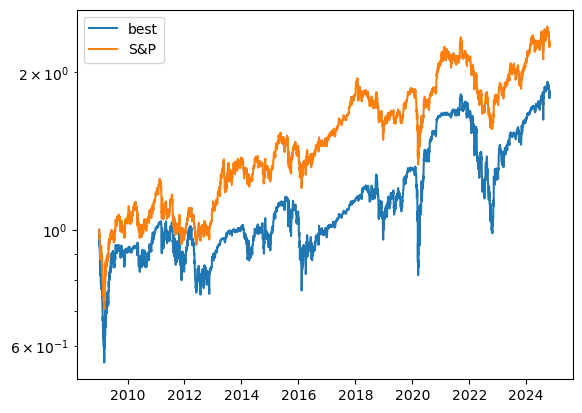

Round 18: 1.0377393493640368
Round 19: 1.1954422045226287
Round 20: 1.5422056516509293
Round 21: 1.2138410516201468
Round 22: 1.1965617189627276
Round 23: 1.3452518640303643
Round 24: 1.8311797674937802
New best: 1.8311797674937802
{'time_param': 111, 'method': 'ew', 't': 0.6321355062725525, 'k': 0.7826964724988879, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


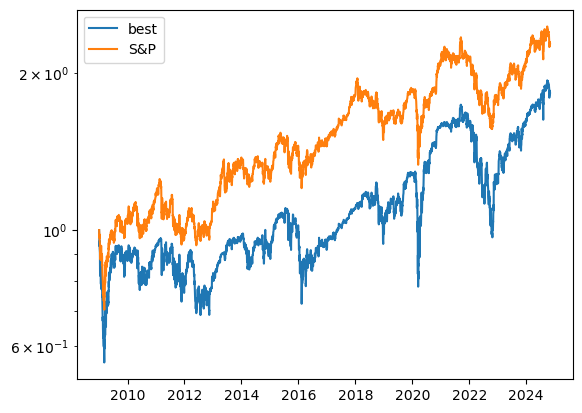

Round 25: 1.0534484023043527
Round 26: 1.8197582247624744
Round 27: 1.3491636051827833
Round 28: 1.3199449391341624
Round 29: 1.0523868611481308
Round 30: 1.0469651572142873
Round 31: 1.1107963241842547
Round 32: 1.2152228311807542
Round 33: 1.1619275363412387
Round 34: 1.260980766129353
Round 35: 1.2403886250439284
Round 36: 1.2552002376276263
Round 37: 1.1685279569256004
Round 38: 1.4531145519686128
Round 39: 1.1628773867363285
Round 40: 1.2162431152143918
Round 41: 1.4656756480861026
Round 42: 1.8412446177360666
New best: 1.8412446177360666
{'time_param': 238, 'method': 'linear', 't': 0.5835354226605276, 'k': 0.9463405601879843, 'as_q': True, 'transform_f': 'bounded_curve'}


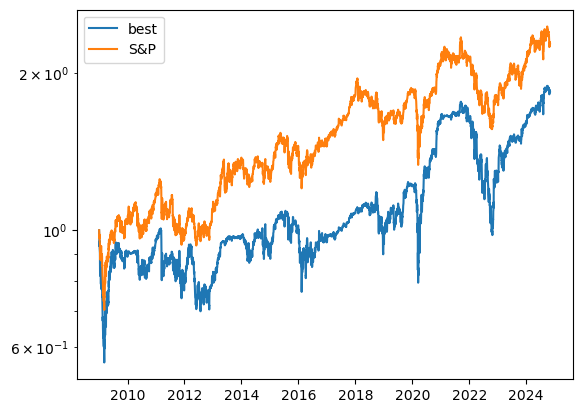

Round 43: 1.741743531518941
Round 44: 1.5770408122227408
Round 45: 1.1176101402262244
Round 46: 1.00632187672667
Round 47: 1.276554338537892
Round 48: 1.9962560100028295
New best: 1.9962560100028295
{'time_param': 84, 'method': 'ma', 't': 0.4846485400124543, 'k': 6.54648613221172, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


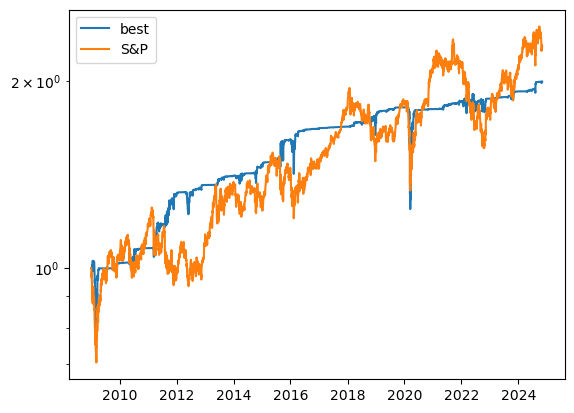

Round 49: 1.1772020668009846
Round 50: 1.074645105897532
Round 51: 1.2262043855567282
Round 52: 1.3416940470760323
Round 53: 1.3611310250296516
Round 54: 1.2275959949797979
Round 55: 1.3456451121073643
Round 56: 1.7356642979043184
Round 57: 1.262041841309355
Round 58: 1.340484165322997
Round 59: 1.0633549952613552
Round 60: 1.334509006211262
Round 61: 1.1717495343272408
Round 62: 1.5824345644066367
Round 63: 1.209354020191583
Round 64: 1.5975726389401732
Round 65: 0.9140392170632203
Round 66: 1.817295297487551
Round 67: 1.0906050292578189
Round 68: 1.4563591868970747
Round 69: 1.286368674008283
Round 70: 1.4898198996036291
Round 71: 1.242135249333296
Round 72: 1.5811447211162233
Round 73: 1.1810539961541795
Round 74: 1.0114942223447951
Round 75: 1.2862081933306528
Round 76: 1.404089252757921
Round 77: 1.4718389243221577
Round 78: 1.210649477808124
Round 79: 1.7026174142547057
Round 80: 1.095277616307748
Round 81: 1.24120157142015
Round 82: 1.2304346089209413
Round 83: 1.502911891157862

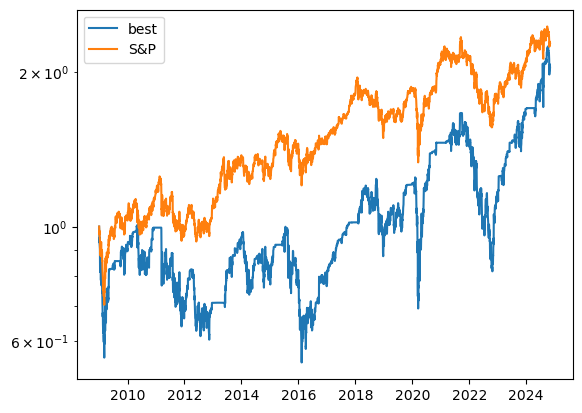

Round 96: 1.185941737994578
Round 97: 1.2970496156295779
Round 98: 1.3124927114520197
Round 99: 1.2441854758578093
Round 100: 1.052386831748578


In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 2.2742273970372184
Round 1: 1.4705807356735545
Round 2: 1.507241079904199
Round 3: 1.5757807303416902
Round 4: 1.4654552193620705
Round 5: 1.6131816755952566
Round 6: 1.0523868250623276
Round 7: 2.0120658846802857
Round 8: 1.7169018446031987
Round 9: 1.0523868250623276
Round 10: 1.0444681461813115
Round 11: 1.9856299060320535
Round 12: 1.6517964248589816
Round 13: 1.8787007859688203
Round 14: 2.091058762495007
New best: 2.091058762495007
{'time_param': 50, 'method': 'ew', 't': 0.6000013064109566, 'k': 7.555724469152315, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


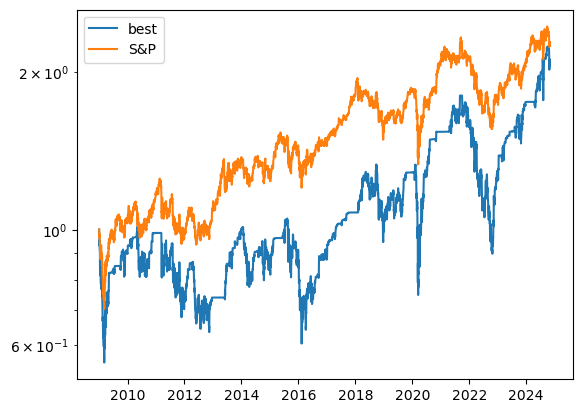

Round 15: 1.8615663128034619
Round 16: 1.8256141613207817
Round 17: 1.548542963109691
Round 18: 2.1976014860402673
New best: 2.1976014860402673
{'time_param': 52, 'method': 'ew', 't': 0.6532938663419444, 'k': 7.277235026995199, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


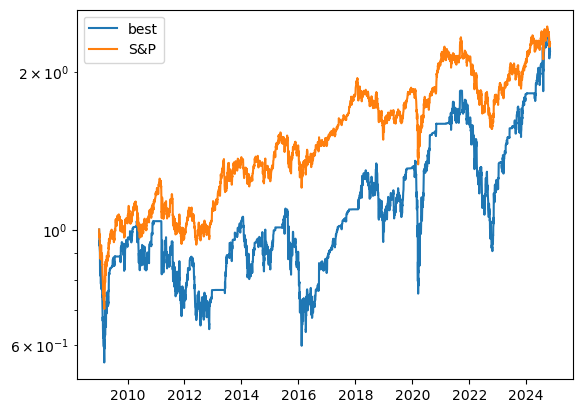

Round 19: 1.8916063436533133
Round 20: 2.126999514197033
Round 21: 2.136331878010182
Round 22: 1.1002282077686094
Round 23: 1.8007971501477804
Round 24: 1.8986813570297323
Round 25: 1.5071022718864027

Factor: 1.03125
Do nothing res: 2.2742273970372184
Round 1: 1.3367922929624296
Round 2: 1.5450484069596966
Round 3: 1.5751234690338438
Round 4: 1.0523868250623276
Round 5: 1.729076992820642
Round 6: 1.5612134674407532
Round 7: 1.5469810813639353
Round 8: 1.2563804208435048
Round 9: 2.1614438783695613
Round 10: 1.0523868250623276
Round 11: 1.5355852653207194
Round 12: 1.8914661014088354
Round 13: 1.887655296640433
Round 14: 1.0523868250623276
Round 15: 1.4965460410967966
Round 16: 2.028528695968812
Round 17: 1.8003967803451024
Round 18: 2.1658566510535593
Round 19: 2.183418941439883
Round 20: 1.6774581681997287
Round 21: 2.1521605574872944
Round 22: 1.2560983911948027
Round 23: 1.0523868250623276
Round 24: 2.05931103209735
Round 25: 1.4065496429727053

Factor: 1.015625
Do nothing res: 2.2

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999942407420879

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.32452960469532194

In [24]:
params_out

{'time_param': 52,
 'method': 'ew',
 't': 0.6532938663419444,
 'k': 7.277235026995199,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


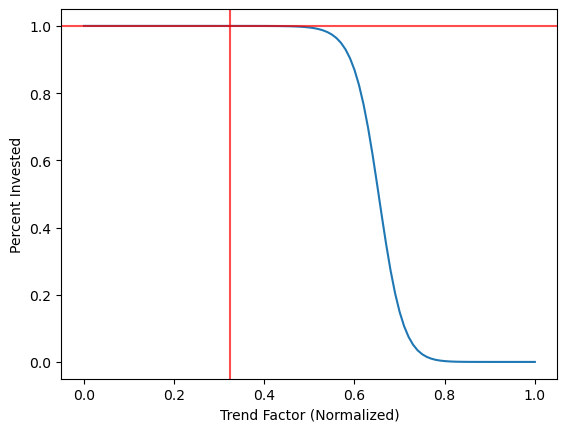

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

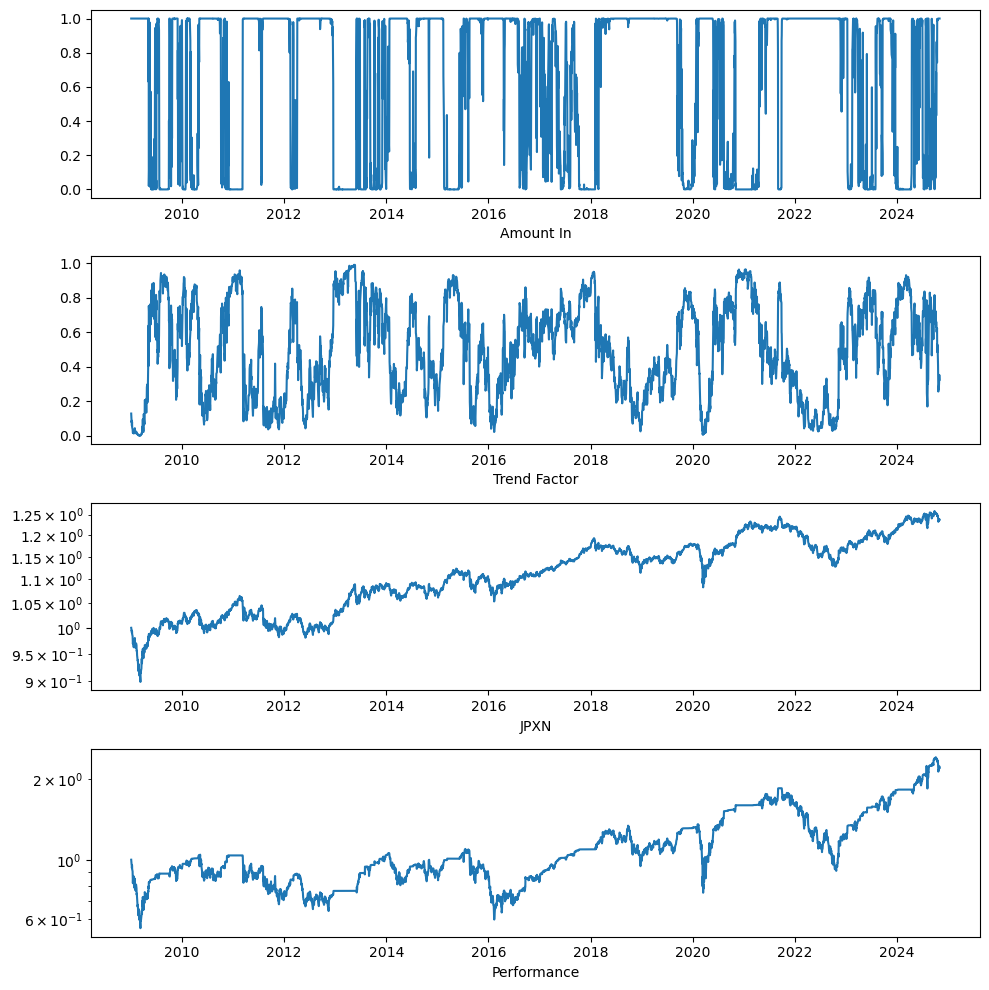

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('JPXN')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

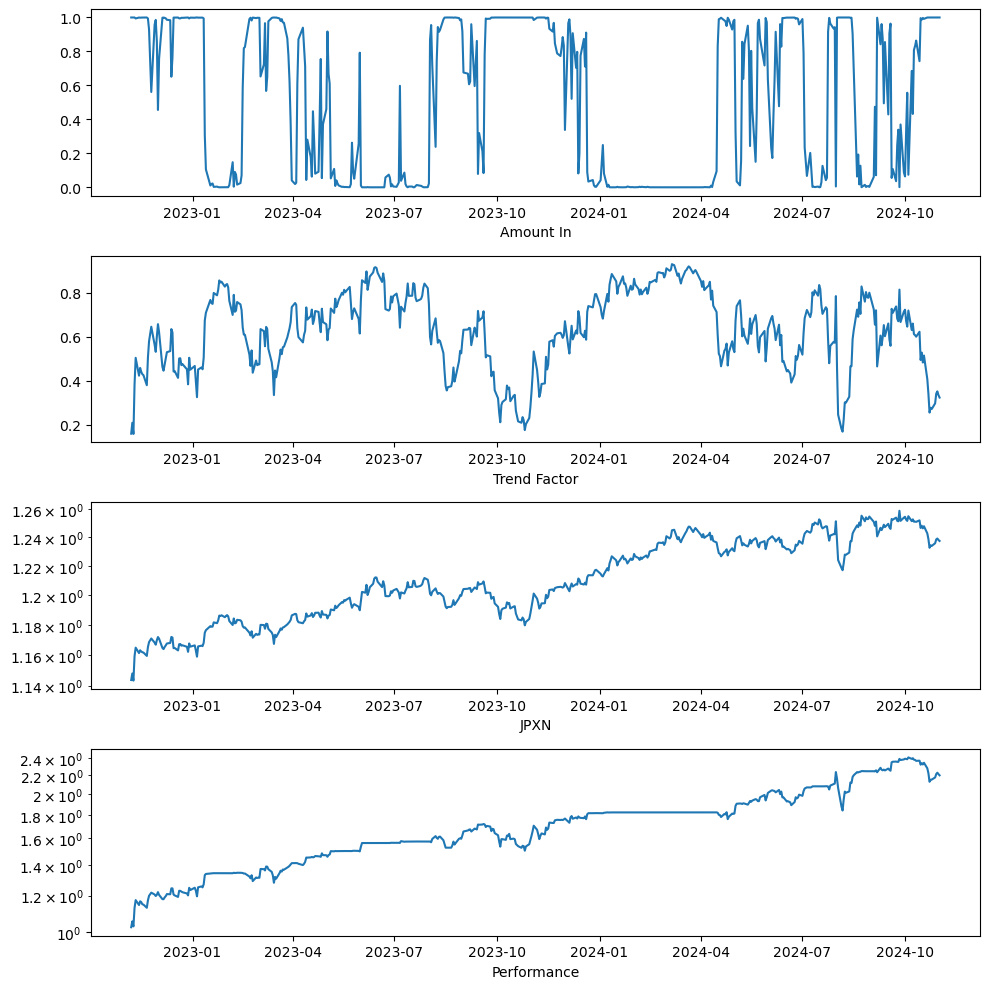

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('JPXN')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(31.791017532348633, 15.944, 72.30000305175781)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.0506229244330223

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['jpxn'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1195809596024326, 1.0], 'nas': [1.2400991798626717, 1.0], 'rus': [1.2734171126746254, 1.0], 'jpxn': [1.0506229244330223, 1.0], 'ktec': [1.6302079070835445, 0.0], 'emb': [1.0676797655679815, 0.9996], 'gdx': [1.3583771630868045, 0.1098], 'dia': [1.2135937638282468, 1.0], 'nfty': [1.2330869591330673, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(2.1976014860402673,
 {'time_param': 52,
  'method': 'ew',
  't': 0.6532938663419444,
  'k': 7.277235026995199,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})